In [1]:
# Bibliotecas necessárias
from numpy import *
from sympy import symbols, Matrix, factor, sympify, solve
from matplotlib.pyplot import plot, legend, xlabel, ylabel, figure, title, tight_layout, step, contour, contourf, axhline, axvline, xlim, ylim, text, gca
from scipy.signal import tf2ss, cont2discrete, TransferFunction

# Funções Desenvolvidas
from mpc import augmented_system, compute_FPhi # funções desenvolvidas para gerar as matrizes aumentadas e ganhos do DMPC
from util import print_matrix

---

## Problema 1.3

In [2]:
z = symbols("z")

Am = Matrix([[1.0, 0.5, 0], [0, 1.0, -0.1], [0, 0, 0.8]])
Bm = Matrix([0.5, 1, -0.6])
Cm = Matrix([1, 0, 1]).T

### Função de transferência em Z para o sistema aumentado

De forma análoga ao realizado para a função de transferência do sistema normal do sistema

Numerador é dado em função de $C adj(z^{-1} - A)B$

In [3]:
A, B, C = augmented_system(Am, Bm, Cm)

Ge_num = C * Matrix.adjugate((z * Matrix.eye(4) - A)) * B
sys_zeros = solve(Ge_num, z)
factor(Ge_num[0,0])

-0.8*(0.125*z**3 - 1.0*z**2 + 0.7125*z - 3.46944695195361e-17)

Os zeros do modelo aumentado

In [4]:
solve(Ge_num[0,0])

[4.86939923081209e-17 - 0.e-36*I,
 0.790638692823757 + 0.e-22*I,
 7.20936130717624 - 0.e-21*I]

O denominador da função de transferência é dado pela equação característica de A

In [5]:
Ge_den = (z * Matrix.eye(4) - A).det()
factor(Ge_den)

1.0*(1.0*z - 1.0)**3*(1.0*z - 0.8)

Polos e Zeros do sistema original

In [6]:
G_num = Cm * Matrix.adjugate(z * Matrix.eye(3) - Am) * Bm
G_den = (z * Matrix.eye(3) - Am).det()
factor(G_num[0,0])
print("Zeros do sistema original", solve(G_num[0,0], z))
print("Polos do sistema original", factor(G_den))

Zeros do sistema original [0.790638692823758, 7.20936130717624]
Polos do sistema original 1.0*(1.0*z - 1.0)**2*(1.0*z - 0.8)


---

## Problema 1.5

Solução da simulação com relação ao sistema em espaço de estados de tempo discreto do tanque.

\begin{equation}
    \begin{aligned}
        x_m(k + 1) &= 0{,}6x_m(k) + 0{,}01u(k) \\
        y(k) &= x_m(k)
    \end{aligned}
\end{equation}

In [7]:
Am = array([[0.6]])
Bm = array([[0.01]])
Cm = array([[1]])

N_p = 16
N_c = 4

A, B, C = augmented_system(Am, Bm, Cm)

F, Phi = compute_FPhi(A, B, C, N_p, N_c)

In [8]:
print_matrix("Phi.T Phi", Phi.T @ Phi)
print_matrix("Phi.T F", Phi.T @ F)

**Phi.T Phi:**

```
0.0085 | 0.0081 | 0.0076 | 0.0071
0.0081 | 0.0079 | 0.0075 | 0.0070
0.0076 | 0.0075 | 0.0072 | 0.0068
0.0071 | 0.0070 | 0.0068 | 0.0066
```

**Phi.T F:**

```
0.5086 | 0.3625
0.4852 | 0.3375
0.4562 | 0.3125
0.4237 | 0.2875
```

Calculando os ganhos do controlador MPC $K_y$ e $K_x$,

one $K_y$ é o primeiro elemento de
\begin{equation}
    (\Phi^T\Phi + \bar{R})^{-1} \Phi^T\bar{R}_S
\end{equation}

e $K_x$ é a primeira linha de
\begin{equation}
    (\Phi^T\Phi + \bar{R})^{-1} \Phi^T F
\end{equation}

In [9]:
R_barra = 1*eye(N_c, N_c)
R_s     = ones((N_p, 1))
temp = linalg.inv(Phi.T @ Phi + R_barra) @ Phi.T

Ky = (temp @ R_s)[0:1]
Kx = (temp @ F)[0:1] 

print("Ganho K_y:", Ky)
print("Ganho K_x:", Kx)

Ganho K_y: [[0.35259486]]
Ganho K_x: [[0.49435224 0.35259486]]


Simulando o comportamento do MPC projetado para o sistema do tanque

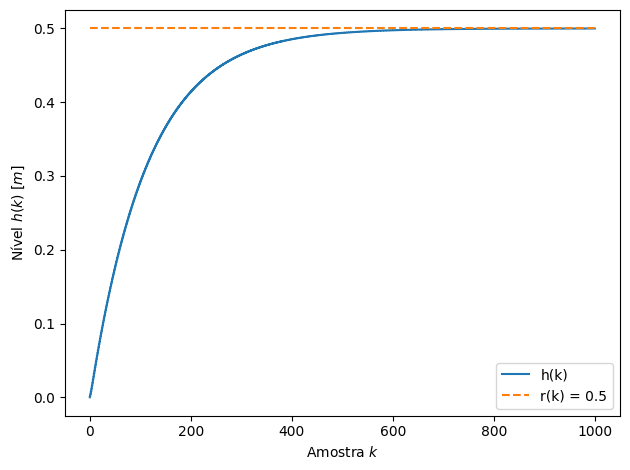

In [10]:
x0 = array([0, 0]).reshape(2, 1)

k_max = 250*4
r = 0.5
x = zeros((k_max, 2, 1))
Delta_u = zeros((k_max, 1))
# Delta_u = 0

for k in range(k_max - 1):
    Delta_u[k] = Ky * r - Kx @ x[k]
    x[k + 1] = A @ x[k] + B * Delta_u[k]

y = x[:,1,:]
t = linspace(0, k_max, k_max)
step(t, y, label="h(k)")
plot([0, k_max], [r, r], '--', label='r(k) = 0.5')
ylabel("Nível $h(k)\ [m]$")
xlabel("Amostra $k$")
legend();
tight_layout();

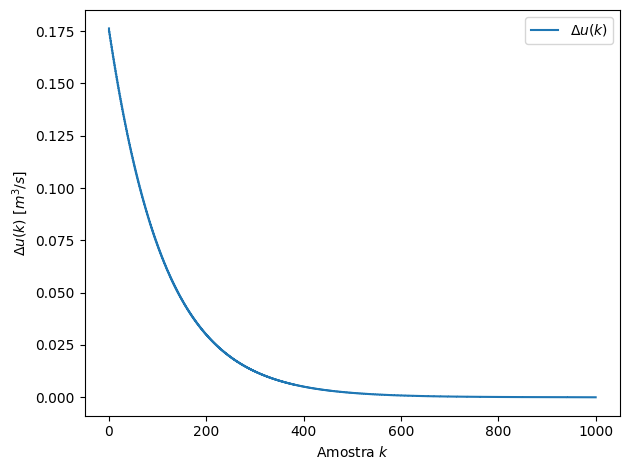

In [11]:
Delta_xm = x[:, 0, :]
step(t, Delta_u, label='$\Delta u(k)$')
ylabel("$\Delta u(k)\ [m^3/s]$")
xlabel("Amostra $k$")
legend();
tight_layout();

---

## Problema 1.8

\begin{equation*}
    G(s)=\frac{0{,}1}{s^2+2 \xi \omega_0 s+\omega_0^2}
\end{equation*}

Usando a transformada de Tustin

\begin{equation*}
    s \approx \frac{2}{T} \frac{z-1}{z+1}
\end{equation*}

Substituindo, teremos $G(z) = G(s \approx \frac{2}{T} \frac{z-1}{z+1})$ 
\begin{equation*}
    G(z)=\frac{0{,}1}{b_0}\frac{z^2+2z+1}{z^2 + b_1z + b_2}
\end{equation*}

Onde 
\begin{equation*}
\begin{aligned}
    \alpha &= \frac{2}{T}\\
    b_0    &= \alpha^2 + 2\xi\omega\alpha + \omega^2 \\
    b_1    &= \frac{2}{b_0}(\omega^2 - \alpha^2) \\
    b_2    &= \frac{1}{b_0}(\alpha^2 - 2\xi\omega\alpha + \omega^2)
\end{aligned}
\end{equation*}

In [12]:
xi = 0.001
omega = 1
T = 0.5
alpha = 2/T

b0 = alpha**2 + 2*xi*omega*alpha + omega**2
b1 = 2*(omega**2 - alpha**2) / b0
b2 = (alpha**2 - 2*xi*omega*alpha + omega**2) / b0

print("Ganho:", round(0.1/b0, 7))
print(f"b0 = {b0:.4f} b1 = {b1:.4f} b2 = {b2:.4f}")


Ganho: 0.0058796
b0 = 17.0080 b1 = -1.7639 b2 = 0.9991


Logo o sistema discretizado é dado por $G(z)$

\begin{equation*}
    G(z)=0{,}05879\frac{z^2+2z+1}{z^2 - 1{,}76z + 1}
\end{equation*}

Transformando em espaço de estados temos:

\begin{equation}
    \begin{aligned}
        \left[\begin{array}{c}
        x_1(k+1) \\
        x_2(k+1)
        \end{array}\right]&=\left[\begin{array}{cc}
        0 & 1 \\
        -b_2 & -b_1
        \end{array}\right] \cdot\left[\begin{array}{l}
        x_1(k) \\
        x_2(k)
        \end{array}\right]+\left[\begin{array}{c} 
        0 \\
        1
        \end{array}\right] \cdot u|k|
        \\
        y(k) &=\left[(1-b_2)\ (2-b_1)\right]+[1] \cdot u(K)
    \end{aligned}
\end{equation}



In [13]:
G0 = 0.1/b0

Am = array([[-b1, -b2], [1, 0]])
Bm = array([[1], [0]])
Cm = G0*array([[-b1+2, -b2+1]])
Dm = G0*array([[1]])

Ts = 0.5
Gs = TransferFunction([0.1], [1, 2*xi*omega, omega**2])
Gz = cont2discrete(([0.1], [1, 2*xi*omega, omega**2]), dt=0.5, method='zoh')
# [Am, Bm, Cm, Dm] = tf2ss(Gz[0], Gz[1])

print_matrix('Am', Am)
print_matrix('Bm', Bm)
print_matrix('Cm', Cm)
print_matrix('Dm', Dm)

**Am:**

```
1.7639 | -0.9991
1.0000 | 0.0000
```

**Bm:**

```
1.0000
0.0000
```

**Cm:**

```
0.0221 | 0.0000
```

**Dm:**

```
0.0059
```

O modelo aumentado é então dado pelas matrizes A, B, C

In [14]:
A, B, C = augmented_system(Am, Bm, Cm, Dm)
print_matrix('A', A)
print_matrix('B', B)
print_matrix('C', C)

**A:**

```
1.7639 | -0.9991 | 0.0000
1.0000 | 0.0000 | 0.0000
0.0390 | -0.0221 | 1.0000
```

**B:**

```
1.0000
0.0000
0.0280
```

**C:**

```
0.0000 | 0.0000 | 1.0000
```

Pode-se projetar o observador de forma independente do controle preditivo.

Dado que os polos do observador ficaram em $0{,}1, 0{,}2 \ \text{e}\ 0{,3}$, o ganho do observador $K_{ob}$ é dado pela expressão derivada da formula de Ackerman, 

\begin{equation}
  Kob = [0 \ 0 \ ... \ 1]P(A^T)W_{ob}^{-1}
\end{equation}

Em que $W_{ob}$ é a matriz de observabilidade do controlador, e P(A) é polinômio característico que desejamos que o sistema em malha fechado possua.

\begin{equation}
  P(A^T) = (A^3)^T + b'_1(A^2)^T + b'_2A^T + b'_3\mathtt{I_3}
\end{equation}

In [15]:
polos_ob = [0.1, 0.2, 0.3]

coef = convolve(convolve([1, -0.1], [1, -0.2]), [1, -0.3])
print('Coeficientes do polinômio característico:', coef)

# Novo polinômio característico
P = linalg.matrix_power(A.T, 3) + coef[1] * linalg.matrix_power(A.T, 2) + coef[2] * A.T + coef[3] * eye(3)

# Matriz de observabilidade
Wob = hstack([
    C.T,
    A.T @ C.T,
    (A @ A).T @ C.T
])
Kob = (linalg.inv(Wob) @ P)[-1,:].reshape((1, -1)).T
print_matrix('P(A)', P)
print_matrix('Kob', Kob)

Coeficientes do polinômio característico: [ 1.    -0.6    0.11  -0.006]


**P(A):**

```
0.8841 | 1.1639 | 0.0821
-1.1628 | -1.1688 | -0.0736
0.0000 | 0.0000 | 0.5040
```

**Kob:**

```
52.8538
40.6866
2.1639
```

Conferindo a alocação de polos do observador através da equação característica $A - K_{ob}C$

In [16]:
linalg.eigvals((A - Kob@C))

array([0.1, 0.2, 0.3])

Projeto do controlador preditivo com $N_c = 20$, $N_p = 60$ e $\bar{R} = 0{,}1I$

In [17]:
N_p = 60
N_c = 20
r_w = 0.1

F, Phi = compute_FPhi(A, B, C, N_p, N_c)
R_barra = r_w*eye(N_c)

R_s     = ones((N_p, 1))
temp = linalg.inv(Phi.T @ Phi + R_barra) @ Phi.T

Ky = (temp @ R_s)[0:1]
Kx = (temp @ F)[0:1] 

print("Ganho K_y:", Ky)
print("Ganho K_x:", Kx)

print(linalg.eigvals(A - B @ Kx))

Ganho K_y: [[2.47623769]]
Ganho K_x: [[ 0.39845367 -0.37862398  2.47623769]]
[0.75971738+0.45053628j 0.75971738-0.45053628j 0.77662893+0.j        ]


Simulando o sistema em malha fechada com controle preditivo e estimação de estados

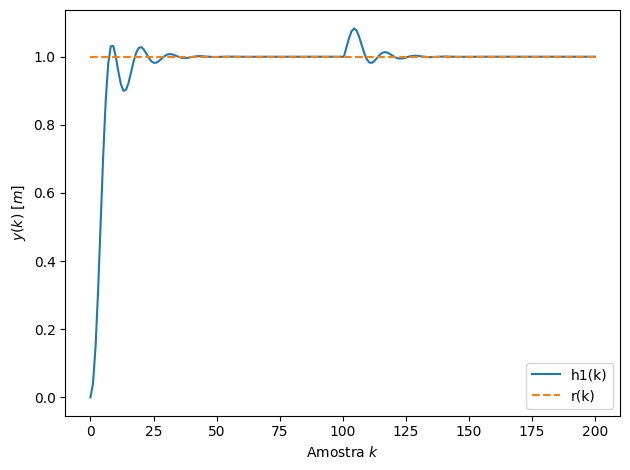

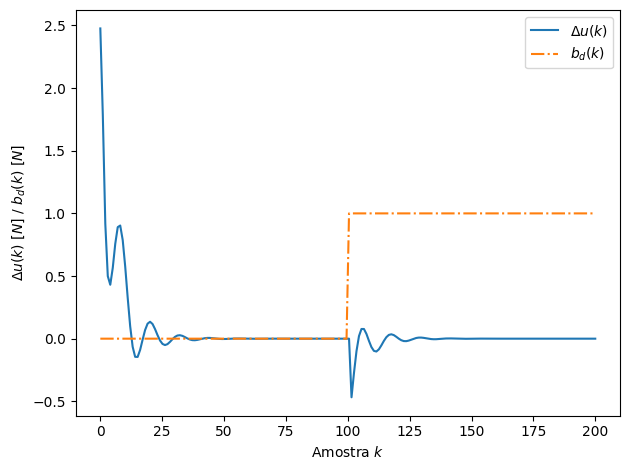

In [18]:
k_max = 200
r = 1
x = zeros((k_max, 3, 1))
x_tilde = zeros((k_max, 3, 1)) # erro de estimação

x[0] = array([0, 0, 0]).reshape(3, 1)
Delta_u = zeros((k_max, 1))

Bd = array([[1],[0], [0]])
bd = zeros((k_max, 1))
bd[100:] = 1

for k in range(k_max - 1):
    Delta_u[k] = Ky * r - Kx @ x[k]
    y = x[k, -1]
    x[k + 1] = A @ x[k] + B * Delta_u[k] + Kob @ (y - C @ x[k]) + B * (bd[k] - bd[k-1])

y = x[:,-1,:] # Saída y(k)
t = linspace(0, k_max, k_max)
figure()
plot(t, y, label="h1(k)")
plot([0, t[-1]], [r, r], '--', label='r(k)')
ylabel("$y(k) \ [m]$")
xlabel("Amostra $k$")
legend();
tight_layout();

figure()
plot(t, Delta_u, label="$\Delta u(k)$")
plot(t, bd, '-.',label="$b_d(k)$")
ylabel("$\Delta u(k)\ [N]$ / $b_d(k) \ [N]$")
xlabel("Amostra $k$")
legend();
tight_layout();

---

## Problema 2.1

Assuma que o conjunto de restrições é definido por:

\begin{equation*}
x\_1 \geq 0, x_2 \geq 0, x_1 + x_2 \leq 3, 2x_1 - x_2 \leq 4, x_2 \leq 2,
\end{equation*}

e a função objetivo é:

\begin{equation*}
J = \frac{1}{2}x^T E x + x^T F,
\end{equation*}

onde

\begin{equation*}
E = \begin{bmatrix}
3 & 1 \\
1 & 1
\end{bmatrix}, \quad
F = \begin{bmatrix}
-15 \\
-7
\end{bmatrix}.
\end{equation*}

1. Encontre o mínimo **sem restrições** da função objetivo $J$.
2. Quantas restrições são **violadas** com essa solução ótima global?
3. Represente graficamente as restrições lineares de desigualdade no plano $(x_1, x_2)$. Marque também a solução ótima global nesse plano. A partir desse gráfico, faça uma **suposição** sobre quais restrições estão ativas na solução ótima do problema de otimização com restrições. **Valide** sua suposição tratando as restrições ativas como **igualdades**.
4. Se sua suposição inicial estiver incorreta, faça outra tentativa para identificar as restrições ativas, até que a validação mostre que você encontrou corretamente o conjunto de restrições ativas.

O mínimo sem restrições é dado por
\begin{equation*}
    x^0 = -E^{-1}F
\end{equation*}

In [19]:
E = array([[3, 1], [1, 1]])
F = array([[-15], [-7]])

x_global = -linalg.inv(E)@F
print("Solução ótima:", x_global.flatten())

Solução ótima: [4. 3.]


A região que satisfaz todas as restrições lineares são

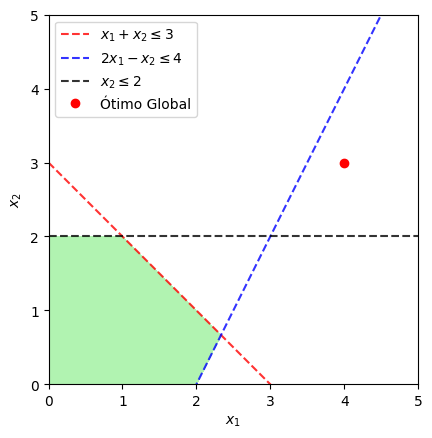

In [20]:
x1 = x2 = linspace(0, 5, 400)

X1, X2 = meshgrid(x1, x2)
ineq1 = X1 >= 0
ineq2 = X2 >= 0
ineq3 = X1 + X2 <= 3
ineq4 = 2*X1 - X2 <= 4
ineq5 = X2 <= 2

feasible_region = ineq1 & ineq2 & ineq3 & ineq4 & ineq5
fig = figure()
plot(x1, 3 - x1, 'r--', alpha=0.8, label=r'$x_1 + x_2 \leq 3$')
plot(x1, 2*x1 - 4, 'b--', alpha=0.8, label=r'$2x_1 - x_2 \leq 4$')
axhline(2, color='k', linestyle='--', alpha=0.8, label=r'$x_2 \leq 2$')
contourf(X1, X2, feasible_region, levels=[0.5, 1], colors=['lightgreen'], alpha=0.7)

# ponto ótimo
plot(x_global[0], x_global[1], 'ro', label='Ótimo Global')
# text(x_global[0], x_global[1] + 0.1, 'Ótimo\nGlobal')

xlabel('$x_1$'), ylabel('$x_2$')
xlim([0, 5]), ylim([0, 5])
legend()
gca().set_aspect('equal', adjustable='box')

A solução considerando as restrições ativas como igualdade é dado por, ao avaliar as condições de Kunh-Tucker:

\begin{equation*}
    \begin{aligned}
    & \lambda=-\left(M E^{-1} M^T\right)^{-1}\left(\gamma+M E^{-1} F\right) \\
    & x=-E^{-1}\left(M^T \lambda+F\right)
    \end{aligned}
\end{equation*}

Supondo que as restrições $x_1 + x_2 \leq 3$ e $2x_1 - x_2 \leq 4 $ estão ativas, temos que $\lambda$ e o $x$ são:

In [21]:
M = array([[1, 1], [2, -1]])
gamma = array([[3], [4]])

E_inv = linalg.inv(E)

lambd = -linalg.inv((M@E_inv@M.T)) @ (gamma + M@E_inv@F)
x = -E_inv@(M.T@lambd + F)
print_matrix('lambda', lambd)
print_matrix('x', x)

**lambda:**

```
5.1111
1.1111
```

**x:**

```
2.3333
0.6667
```

In [22]:
M = array([[1, 1], [2, -1]])
gamma = array([[3], [4]])

E_inv = linalg.inv(E)

lambd = -linalg.inv((M@E_inv@M.T)) @ (gamma + M@E_inv@F)
x_f2 = -E_inv@(M.T@lambd + F)
print_matrix('lambda', lambd)
print_matrix('x', x)

**lambda:**

```
5.1111
1.1111
```

**x:**

```
2.3333
0.6667
```

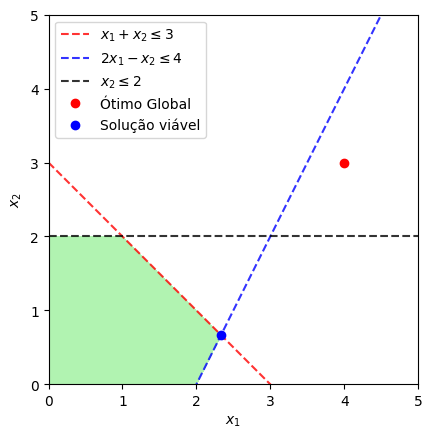

In [23]:
x1 = x2 = linspace(0, 5, 400)

X1, X2 = meshgrid(x1, x2)
ineq1 = X1 >= 0
ineq2 = X2 >= 0
ineq3 = X1 + X2 <= 3
ineq4 = 2*X1 - X2 <= 4
ineq5 = X2 <= 2

feasible_region = ineq1 & ineq2 & ineq3 & ineq4 & ineq5
fig = figure()
plot(x1, 3 - x1, 'r--', alpha=0.8, label=r'$x_1 + x_2 \leq 3$')
plot(x1, 2*x1 - 4, 'b--', alpha=0.8, label=r'$2x_1 - x_2 \leq 4$')
axhline(2, color='k', linestyle='--', alpha=0.8, label=r'$x_2 \leq 2$')
contourf(X1, X2, feasible_region, levels=[0.5, 1], colors=['lightgreen'], alpha=0.7)

# ponto ótimo
plot(x_global[0], x_global[1], 'ro', label='Ótimo Global')
plot(x[0], x[1], 'bo', label='Solução viável')
# text(x_global[0], x_global[1] + 0.1, 'Ótimo\nGlobal')

xlabel('$x_1$'), ylabel('$x_2$')
xlim([0, 5]), ylim([0, 5])
legend()
gca().set_aspect('equal', adjustable='box')

---

## Problema 2.3

Considere o modelo de motor DC em tempo discreto

\begin{equation}
    \begin{bmatrix}
    x_1(k+1) \\
    x_2(k+1)
    \end{bmatrix}
    =
    \begin{bmatrix}
    0.9048 & 0 \\
    0.0952 & 1
    \end{bmatrix}
    \begin{bmatrix}
    x_1(k) \\
    x_2(k)
    \end{bmatrix}
    +
    \begin{bmatrix}
    0.0952 \\
    0.0048
    \end{bmatrix}
    u(k)
\end{equation}

\begin{equation}
    y(k) =
    \begin{bmatrix}
    0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    x_1(k) \\
    x_2(k)
    \end{bmatrix}
\end{equation}

Assumindo que apenas a posição do eixo (shaft position) é medida, projete um sistema de controle preditivo que siga um sinal de referência unitário com restrições. O sistema observador em malha fechada deve possuir polos em 0.1, 0.2 e 0.3, e o sinal de controle deve satisfazer as seguintes restrições:

\begin{equation*}
0 \leq u(k) \leq 0.6; \quad -0.2 \leq \Delta u(k) \leq 0.2
\end{equation*}

O horizonte de predição é $N_p = 60$, e o horizonte de controle é $N_c = 5$; $\bar{R} = I$. As condições iniciais do vetor de estado da planta e dos estados do observador são assumidas como sendo nulas.

In [24]:
Am = array([[0.9048, 0], [0.0952, 1]])
Bm = array([[0.0952], [0.0048]])
Cm = array([[0, 1]])

A, B, C = augmented_system(Am, Bm, Cm)

print("Sistema Aumentado:")
print_matrix("A", A)
print_matrix("B", B)
print_matrix("C", C)

coef = convolve(convolve([1, -0.1], [1, -0.2]), [1, -0.3])
print('Coeficientes do polinômio característico (observador):', coef)

# Novo polinômio característico
P = linalg.matrix_power(A.T, 3) + coef[1] * linalg.matrix_power(A.T, 2) + coef[2] * A.T + coef[3] * eye(3)

# Matriz de observabilidade
Wob = hstack([C.T, A.T @ C.T, (A @ A).T @ C.T])
Kob = (linalg.inv(Wob) @ P)[-1,:].reshape((1, -1)).T

print_matrix('Kob', Kob)

Sistema Aumentado:


**A:**

```
0.9048 | 0.0000 | 0.0000
0.0952 | 1.0000 | 0.0000
0.0952 | 1.0000 | 1.0000
```

**B:**

```
0.0952
0.0048
0.0048
```

**C:**

```
0.0000 | 0.0000 | 1.0000
```

Coeficientes do polinômio característico (observador): [ 1.    -0.6    0.11  -0.006]


**Kob:**

```
3.9827
1.3114
2.3048
```

Considerando as restrições na entrada do sinal controlado $u$ e nos incrementos de $\Delta u$ e aplicados apenas no primeiro elemento calculado do horizonte de controle.

\begin{equation*}
    \begin{aligned}
        0    & \leq  u(k)       & \leq 0.6 \\
        -0.2 & \leq \Delta u(k) & \leq 0.2
    \end{aligned}    
\end{equation*}

Para as restrições em $\Delta u(k)$

\begin{equation*}
    M_1:
    \overbrace{
    \begin{bmatrix}
        1  & 0 & ... & 0 \\
        -1 & 0 & ... & 0 \\
    \end{bmatrix}
    }^
    {N_c}
    \Delta U
    \leq
    \begin{bmatrix}
        0.6 \\
        0.2
    \end{bmatrix}
\end{equation*}

Para as restrições em $u(k)$

\begin{equation*}
    M_2:
    \overbrace{
    \begin{bmatrix}
        1  & 0 & ... & 0 \\
        -1 & 0 & ... & 0 \\
    \end{bmatrix}
    }^
    {N_c}
    \Delta U
    \leq
    \begin{bmatrix}
        0.6 \\
        0
    \end{bmatrix}
    +
    \begin{bmatrix}
        -u(k-1) \\
        u(k-1)
    \end{bmatrix}
\end{equation*}

As restrições combinadas serão dadas pela concatenação de $M_1$ e $M_2$

In [25]:
def gerarMatrizesRestricoes(N_c, du_cons, u_cons, apply='first'):
    du_min, du_max = du_cons
    u_min, u_max   = u_cons

    I = ones((N_c))
    R = ones((N_c, N_c))

    M_1 = vstack([diag(I), diag(-I)])
    M_2 = vstack([tril(R), tril(-R)])
    
    gamma_1 = hstack([I * du_max, -I * du_min]).reshape((-1, 1))
    gamma_2 = hstack([I * u_max, -I * u_min]).reshape((-1, 1))
    
    mask = hstack([zeros(2*N_c), -I, +I]).reshape((-1, 1)) # mascara para adicionar o termo u(k - 1)

    if(apply == 'first'): # aplica apenas a primeira amostra
        M_1 = M_1[[0, N_c], :]
        M_2 = M_2[[0, N_c], :]
        gamma_1 = gamma_1[[0, N_c]]
        gamma_2 = gamma_2[[0, N_c]]
        mask    = mask[[0, N_c, 2*N_c, 3*N_c]]

    M = vstack([M_1, M_2])
    _gamma_ = vstack([gamma_1, gamma_2])
    gamma = lambda u: _gamma_ + mask * u 
    # gamma_2_ = lambda u: gamma_2 + mask[2:] * u 

    return M, gamma, _gamma_, mask

du_range = [-0.2, 0.2]
u_range  = [0, 0.6]
M, gamma, _, mask = gerarMatrizesRestricoes(5, du_range, u_range, apply='first')

print_matrix("M", M)
print_matrix("gamma(u(k) = 0)", gamma(0))

**M:**

```
1.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000
-1.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000
1.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000
-1.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000
```

**gamma(u(k) = 0):**

```
0.2000
0.2000
0.6000
0.0000
```

In [26]:
from mpc import HildrethQP, mpc_gains

def r(k): # função para o sinal de referência
    return ones((1, 1))

k_total = 80
N_p = 60
N_c = 5
r_w = 0.1


n_state  = A.shape[0]

x = zeros((k_total, n_state, 1))
Du = zeros((k_total, 1, 1))

x_cons = zeros((k_total, n_state, 1))
x_cons2 = zeros((k_total, n_state, 1))
Du_cons = zeros((k_total, 1, 1))
Du_cons2 = zeros((k_total, 1, 1))

M, gamma, _, _ = gerarMatrizesRestricoes(N_c, du_range, u_range, apply='first')
M_all, gamma_all, _, _ = gerarMatrizesRestricoes(N_c, du_range, u_range, apply='all')
F, Phi = compute_FPhi(A, B, C, N_p, N_c)

R_bar  = r_w * eye(N_c)
E = 2*(Phi.T @ Phi + R_bar) 
f_r = -2*Phi.T @ ones((N_p, 1))
f_x = 2*Phi.T @ F

u_k = 0
u_k2 = 0

Ky, Kx = mpc_gains(A, B, C, N_p, N_c, r_w)

for ki in range(0, k_total-1):
    # simulação do DMPC sem restrições
    Du[ki] = Ky * r(ki) - Kx @ x[ki]
    x[ki + 1] = A @ x[ki] + B @ Du[ki]

    # simulação do DMPC com restrição no primeiro elemento de controle
    f = f_r @ r(ki) + f_x @ x_cons[ki]
    DeltaU = HildrethQP(E, f, M, gamma(u_k), p_max=80)
    Du_cons[ki] = DeltaU[0, 0]
    u_k += DeltaU[0, 0] # u_k precisa ser uma constante (e.g: float)
    x_cons[ki + 1] = A @ x_cons[ki] + B * Du_cons[ki]

    # simulação do DMPC com restrição em todos os elementos de controle
    f = f_r @ r(ki) + f_x @ x_cons2[ki]
    DeltaU = HildrethQP(E, f, M_all, gamma_all(u_k2), p_max=80)
    Du_cons2[ki] = DeltaU[0, 0]
    u_k2 += DeltaU[0, 0] # u_k precisa ser uma constante (e.g: float)
    x_cons2[ki + 1] = A @ x_cons2[ki] + B * Du_cons2[ki]


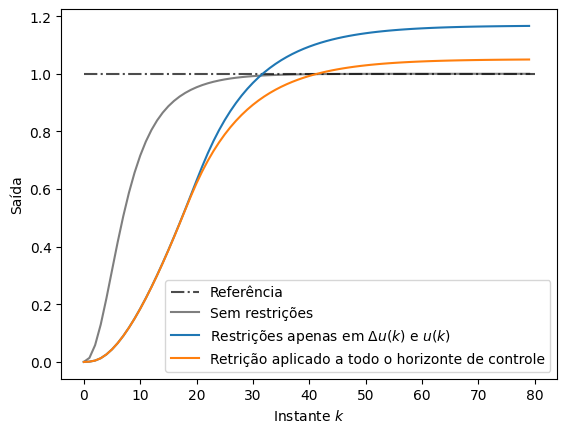

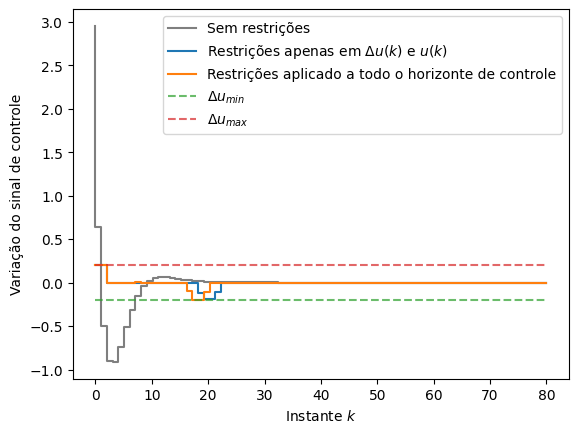

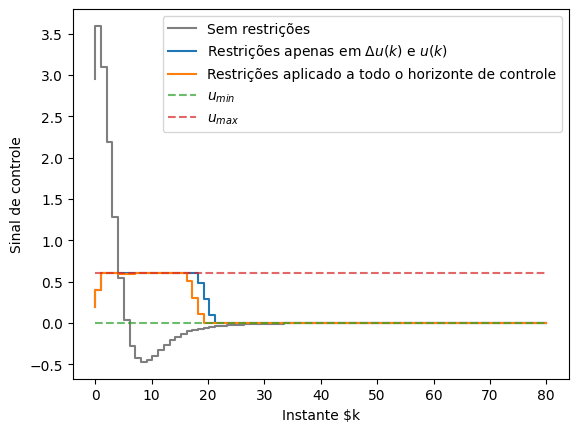

In [27]:
k = linspace(0, k_total, k_total)

figure()
plot([0, k[-1]], [1, 1], 'k-.',  label='Referência', alpha=0.7)
plot(x[:, -1], 'k-',  label='Sem restrições', alpha=0.5)
plot(x_cons[:, -1],   label='Restrições apenas em $\Delta u(k)$ e $u(k)$')
plot(x_cons2[:, -1],  label='Retrição aplicado a todo o horizonte de controle')
ylabel('Saída')
xlabel('Instante $k$')
legend();

figure()
step(k, Du[:, 0, 0], 'k-', alpha=0.5, label='Sem restrições')
step(k, Du_cons[:, 0, 0],  label='Restrições apenas em $\Delta u(k)$ e $u(k)$')
step(k, Du_cons2[:, 0, 0], label='Restrições aplicado a todo o horizonte de controle')
plot([0, k[-1]], [du_range[0], du_range[0]], '--', alpha=0.7, label='$\Delta u_{min}$')
plot([0, k[-1]], [du_range[1], du_range[1]], '--', alpha=0.7, label='$\Delta u_{max}$')
ylabel("Variação do sinal de controle")
xlabel("Instante $k$")
legend();

figure()
step(k, cumsum(Du[:, 0, 0]), 'k-', label='Sem restrições', alpha=0.5)
step(k, cumsum(Du_cons[:, 0, 0]),  label='Restrições apenas em $\Delta u(k)$ e $u(k)$')
step(k, cumsum(Du_cons2[:, 0, 0]), label='Restrições aplicado a todo o horizonte de controle')
plot([0, k[-1]], [u_range[0], u_range[0]], '--', alpha=0.7, label='$u_{min}$')
plot([0, k[-1]], [u_range[1], u_range[1]], '--', alpha=0.7, label='$u_{max}$')
ylabel("Sinal de controle")
xlabel("Instante $k")
legend();


...

considerando as restrições em todos os elementos do horizonte de controle


Para as restrições em $u(k)$

\begin{equation*}
    M_2:
    \begin{bmatrix}
       +R \\
       -R 
    \end{bmatrix}
    \Delta U
    \leq
    \begin{bmatrix}
        0.6 \\
        0
    \end{bmatrix}
    +
    \begin{bmatrix}
        -u(k-1) \\
        u(k-1)
    \end{bmatrix}
\end{equation*}

onde $\mathbf{R} \in \mathbb{R}^{N_c \times N_c},\quad \text{matriz triangular inferior}$